In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sp

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, auc
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from scipy import stats

from catboost import CatBoostClassifier

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# I/ Exploration

In [3]:
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
df.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
#Check du type, de la proportion de N/A et du nombre de valeurs uniques pour chaque colonne

print(f"Dataset Shape: {df.shape}") 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (253680, 22)
**Variable Description of  data:**


,index,dtypes,Missing,PercMissing,Uniques
0,Diabetes_binary,float64,0,0.0,2
1,HighBP,float64,0,0.0,2
2,HighChol,float64,0,0.0,2
3,CholCheck,float64,0,0.0,2
4,BMI,float64,0,0.0,84
5,Smoker,float64,0,0.0,2
6,Stroke,float64,0,0.0,2
7,HeartDiseaseorAttack,float64,0,0.0,2
8,PhysActivity,float64,0,0.0,2
9,Fruits,float64,0,0.0,2


In [5]:
#Colonne Target
target_column = "Diabetes_binary"

#Colonnes Numériques
numerical_columns = [
    'BMI', 'GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income'
]

#Colonnes Catégorielles
categorical_columns = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex',
]


#On force le type pour chaque type de colonnes
for l in numerical_columns: df[l] = df[l].astype('float')
for l in categorical_columns: df[l] = df[l].astype('string').fillna("None").astype('category')
df[target_column] = df[target_column].astype('int')

#On ordonne notre df
df = df[ [target_column] + numerical_columns + categorical_columns ]

#On supprime les lignes ou la target est n/a
df = df.dropna(subset=target_column)

In [6]:
df.describe()

,Diabetes_binary,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,28.382364,2.511392,3.184772,4.242081,8.032119,5.050434,6.053875
std,0.346294,6.608694,1.068477,7.412847,8.717951,3.054220,0.985774,2.071148
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,24.000000,2.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,27.000000,2.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,31.000000,3.000000,2.000000,3.000000,10.000000,6.000000,8.000000
max,1.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


# II/ Check Variables
## a) Colinearity

In [7]:
corr=df[numerical_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
BMI,1.000000,0.239185,0.085310,0.121141,-0.036618,-0.103932,-0.100069
GenHlth,0.239185,1.000000,0.301674,0.524364,0.152450,-0.284912,-0.370014
MentHlth,0.085310,0.301674,1.000000,0.353619,-0.092068,-0.101830,-0.209806
PhysHlth,0.121141,0.524364,0.353619,1.000000,0.099130,-0.155093,-0.266799
Age,-0.036618,0.152450,-0.092068,0.099130,1.000000,-0.101901,-0.127775
Education,-0.103932,-0.284912,-0.101830,-0.155093,-0.101901,1.000000,0.449106
Income,-0.100069,-0.370014,-0.209806,-0.266799,-0.127775,0.449106,1.000000


In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        
cramers_v_matrix.astype(float).style.background_gradient(cmap='coolwarm')

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
HighBP,0.999992,0.298191,0.098487,0.096983,0.129555,0.209348,0.125258,0.040546,0.061256,0.003954,0.038406,0.017344,0.223608,0.052199
HighChol,0.298191,0.999992,0.085621,0.091291,0.092600,0.180752,0.078037,0.040851,0.039863,0.011525,0.042211,0.013296,0.144661,0.031197
CholCheck,0.098487,0.085621,0.999945,0.009908,0.024105,0.044170,0.004165,0.023828,0.006094,0.023685,0.117577,0.058218,0.040557,0.022094
Smoker,0.096983,0.091291,0.009908,0.999992,0.061153,0.114428,0.087392,0.077658,0.030668,0.101601,0.023232,0.048932,0.122453,0.093654
Stroke,0.129555,0.092600,0.024105,0.061153,0.999949,0.202968,0.069128,0.013369,0.041099,0.016907,0.008730,0.034768,0.176540,0.002958
HeartDiseaseorAttack,0.209348,0.180752,0.044170,0.114428,0.202968,0.999977,0.087283,0.019776,0.039150,0.028961,0.018703,0.030975,0.212691,0.086082
PhysActivity,0.125258,0.078037,0.004165,0.087392,0.069128,0.087283,0.999989,0.142746,0.153138,0.012372,0.035483,0.061622,0.253162,0.032472
Fruits,0.040546,0.040851,0.023828,0.077658,0.013369,0.019776,0.142746,0.999992,0.254332,0.035270,0.031525,0.044228,0.048341,0.091167
Veggies,0.061256,0.039863,0.006094,0.030668,0.041099,0.039150,0.153138,0.254332,0.999987,0.021043,0.029560,0.032214,0.080492,0.064755
HvyAlcoholConsump,0.003954,0.011525,0.023685,0.101601,0.016907,0.028961,0.012372,0.035270,0.021043,0.999963,0.010448,0.004653,0.037645,0.005723


## b) Distribution

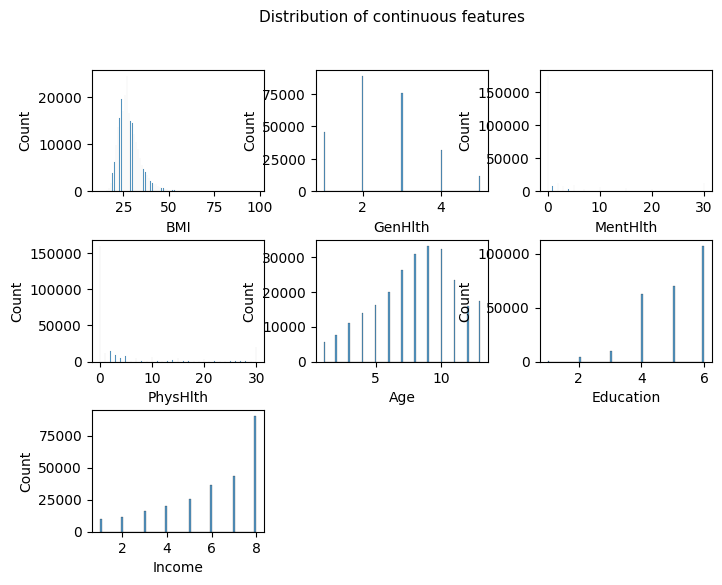

In [9]:
nb_cols=3
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of continuous features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(numerical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    sns.histplot(df[col], ax=ax)

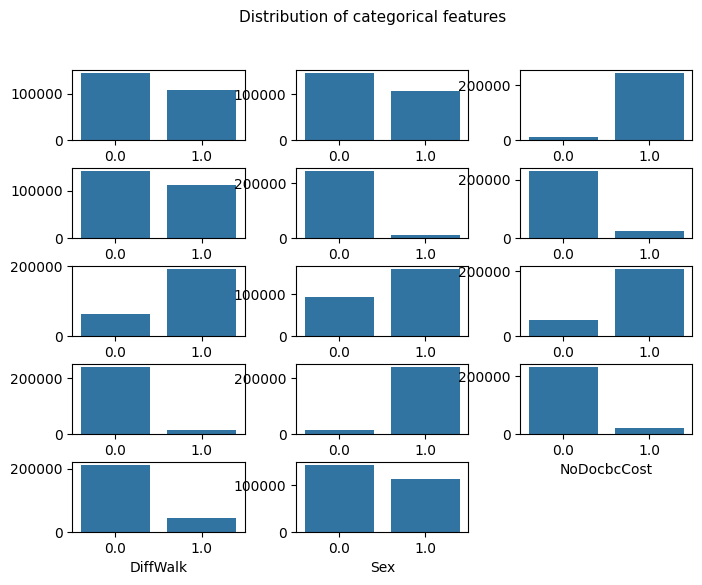

In [10]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of categorical features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(categorical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    plot = sns.countplot(df, x=col)
    plt.ylabel('')

# III/ Preprocessing

In [11]:
#Train/test split
 
X = df.drop(target_column, axis=1)
y = df[target_column]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
n_classes= np.unique(y).size
 
#matrice des probas
lb = LabelBinarizer().fit(y)
Y_train = lb.transform(y_train) 
Y_test = lb.transform(y_test) 
 
print("Kolmogorov p_value (train/test même distrib):", np.round(stats.ks_2samp(y_train, y_test)[1],3))
print("Shape of train X,y,Y: ",X_train.shape, y_train.shape, Y_train.shape)
print("Shape of test X,y,Y: ",X_test.shape, y_test.shape, Y_test.shape)
print("Number of classes: ", n_classes)

Kolmogorov p_value (train/test même distrib): 1.0
Shape of train X,y,Y:  (202944, 21) (202944,) (202944, 1)
Shape of test X,y,Y:  (50736, 21) (50736,) (50736, 1)
Number of classes:  2


In [12]:
#On vérifie le ratio 0/1 dans nos échantillons train et test:

Balance_train = np.unique(y_train, return_counts=True)
Prop_train = Balance_train[1]/np.sum(Balance_train[1])
 
Balance_test = np.unique(y_test, return_counts=True)
Prop_test = Balance_test[1]/np.sum(Balance_test[1])
 
print("Balance_train:", Balance_train)
print("Balance_test:", Balance_test)
print("-"*80)
print("Prop_train:", Prop_train)
print("Prop_test:", Prop_test)

Balance_train: (array([0, 1]), array([174595,  28349], dtype=int64))
Balance_test: (array([0, 1]), array([43739,  6997], dtype=int64))
--------------------------------------------------------------------------------
Prop_train: [0.86031122 0.13968878]
Prop_test: [0.86209003 0.13790997]


# IV/ Modelisation
## a) CV

In [13]:
#Calibrations du seuil de décision
#CV sur 5 fold, grid search
#Le choix de la metric de validation sera le f1-score de la classe 1 afin de prendre en compte la quantité
# et la qualité des prédictions de la classe minoritaire

K_fold=5
skf = StratifiedKFold(n_splits=K_fold)
grid = np.arange(0.1,0.65,0.025)
K = np.arange(0,K_fold)

cv_result = np.zeros((K_fold, grid.size))
for (train, valid), k in zip(skf.split(X_train, y_train), K):
    clf_catboost_cv = CatBoostClassifier(loss_function="Logloss", logging_level='Silent', cat_features = categorical_columns)
    clf_catboost_cv.fit(X_train.iloc[train], y_train.iloc[train])
    y_hat = clf_catboost_cv.predict_proba(X_train.iloc[valid])
    
    for t_i in range(grid.size): 
        cv_result[k,t_i] = f1_score(y_train.iloc[valid], (y_hat[:,1] >= grid[t_i]).astype("int"), average="macro")

threshold = grid[np.argmax(cv_result.mean(axis=0))]

print("Score atteint:", np.max(cv_result.mean(axis=0)))
print("Seuil optimal:", np.round(threshold,3))

Score atteint: 0.6789295442158017
Seuil optimal: 0.275


## b) Training

In [14]:
clf_catboost = CatBoostClassifier(cat_features = categorical_columns, verbose = False)
clf_catboost = clf_catboost.fit(X_train, y_train, verbose = False, plot=True, eval_set= (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
#Result model:

#Probabilités
Y_hat_train = clf_catboost.predict_proba(X_train)
Y_hat_test = clf_catboost.predict_proba(X_test)

#Labels
y_hat_train = Y_hat_train[:,1] >= threshold
y_hat_test = Y_hat_test[:,1] >= threshold

# V/ Evaluation
## a) Probability

In [16]:
#Loss
print("Train loss: ", log_loss(Y_train, Y_hat_train))
print("Test loss: ", log_loss(Y_test, Y_hat_test))
 
print("Test loss (random): ", log_loss(Y_test, np.ones(n_test)*Prop_test[1]))

Train loss:  0.3079152646278643
Test loss:  0.3068874325318723
Test loss (random):  0.4011512493459805


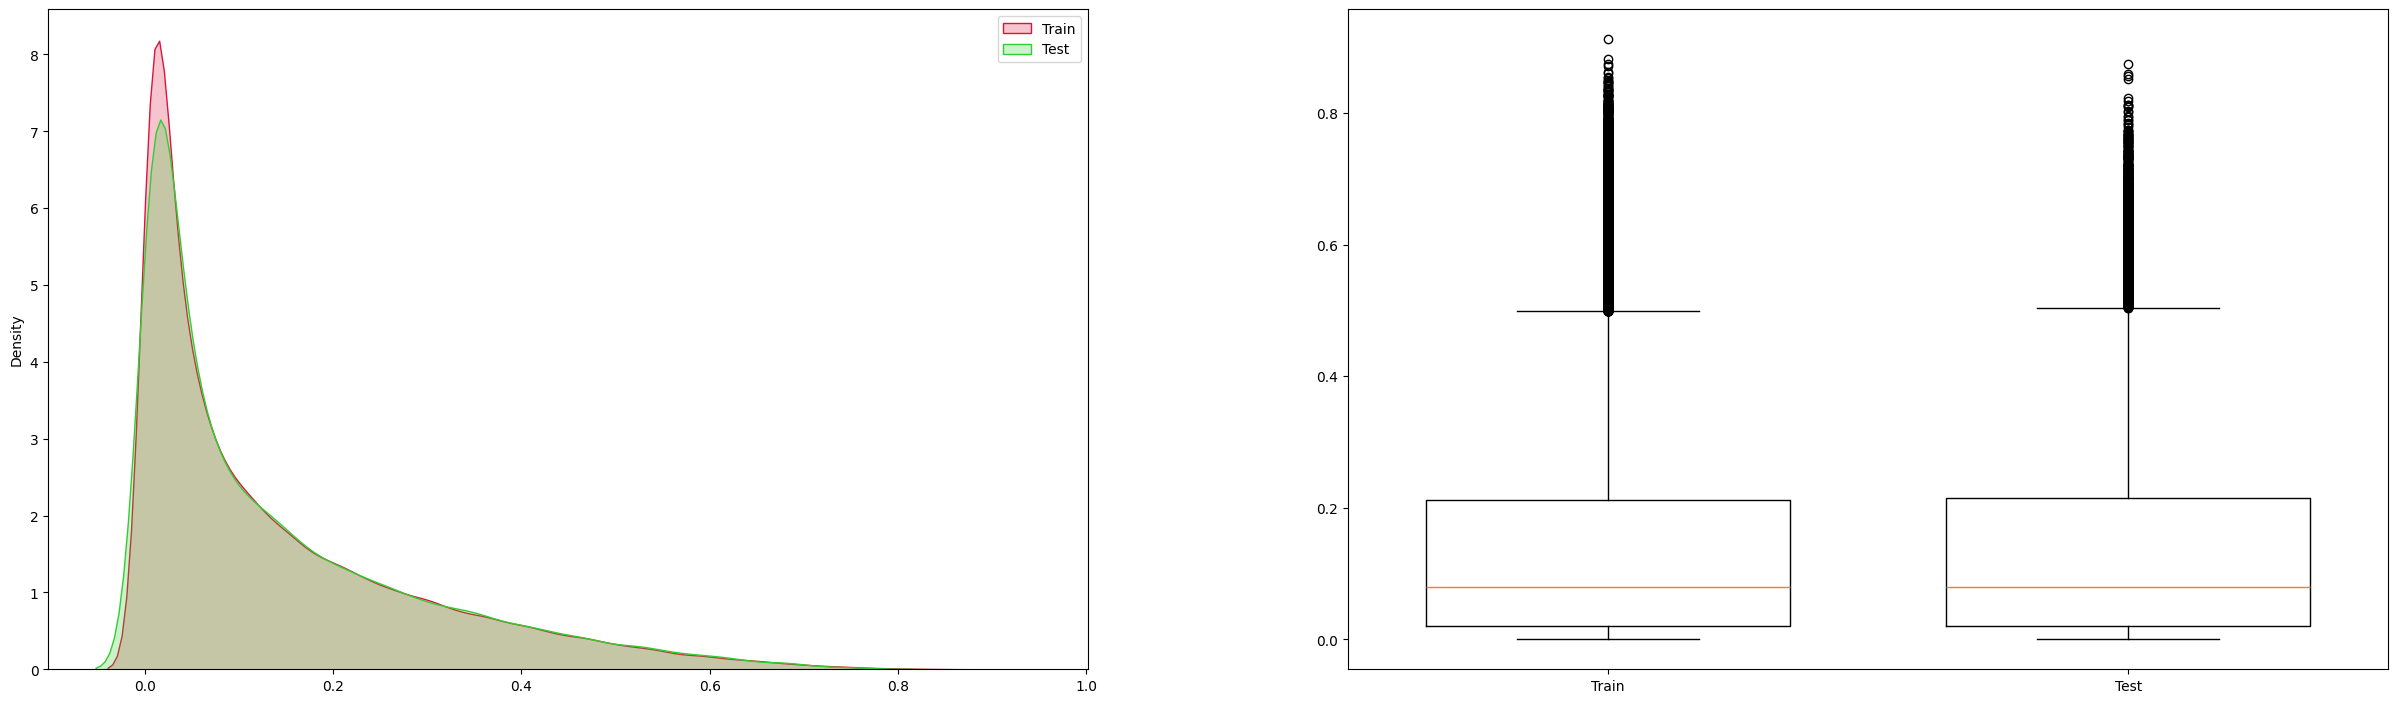

In [17]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
 
sns.kdeplot(data=Y_hat_train[:,1], color='crimson', label="Train", fill=True, ax=ax0)
sns.kdeplot(data=Y_hat_test[:,1], color='limegreen', label="Test", fill=True, ax=ax0)
ax0.legend()
 
ax1.boxplot([Y_hat_train[:,1], Y_hat_test[:,1]], widths=0.7, labels = ["Train", "Test"])
 
plt.subplots_adjust(left=0.05, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

AUC ROC: CatBoost:  0.836 VS Random: 0.5
AUC PR: CatBoost:  0.437 VS Random: 0.138


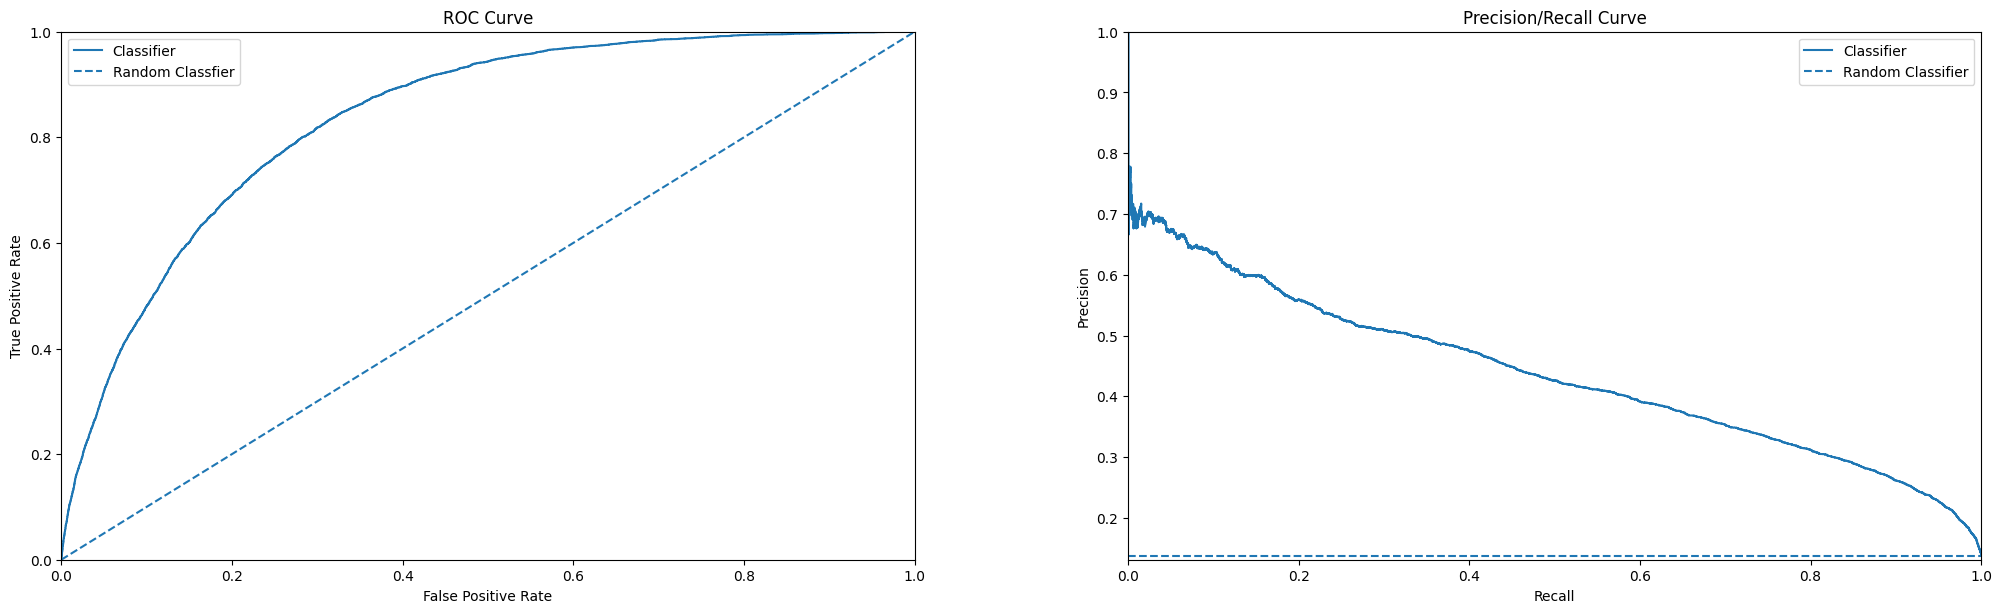

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, Y_hat_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Y_hat_test[:,1])
 
fig, (ax1, ax0) = plt.subplots(nrows=1,ncols=2)
 
PrecisionRecallDisplay(precision= precision, recall= recall).plot(ax = ax0, label = "Classifier") 
ax0.axhline(y=Prop_test[1], linestyle="--", label='Random Classifier')
ax0.legend(), ax0.set(xlim=(0, 1), ylim=(Prop_test[1]*0.95, 1), title="Precision/Recall Curve")


RocCurveDisplay(fpr= fpr, tpr= tpr).plot(ax = ax1, label = "Classifier")
ax1.axline((0, 0), slope=1, linestyle = "--", label = 'Random Classfier')
ax1.legend(), ax1.set(xlim=(0, 1), ylim=(0, 1), title="ROC Curve")

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

print("AUC ROC: CatBoost: ", np.round(auc(fpr, tpr),3), "VS Random:", 0.5)
print("AUC PR: CatBoost: ", np.round(auc(recall, precision),3), "VS Random:", np.round(Prop_test[1],3))

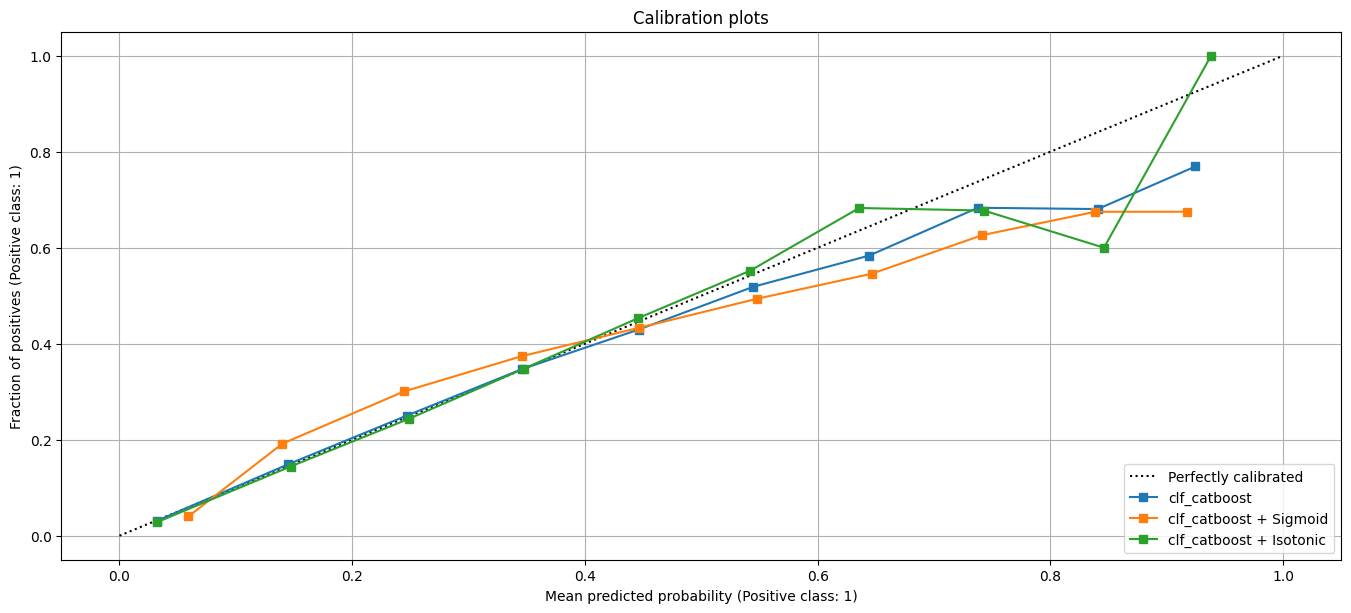

In [19]:
clf_list = [
    (clf_catboost, "clf_catboost"),
    (CalibratedClassifierCV(clf_catboost, cv=5, method="sigmoid"), "clf_catboost + Sigmoid"),
    (CalibratedClassifierCV(clf_catboost, cv=5, method="isotonic"), "clf_catboost + Isotonic"),
]

fig, axis = plt.subplots()

calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(clf, X_test, y_test,
        n_bins=10, name=name, ax=axis, )
    calibration_displays[name] = display

axis.legend(loc='lower right')
axis.grid()
axis.set_title("Calibration plots")

plt.subplots_adjust(left=-1, bottom=-1, right=1, top=0.1, wspace=0.25, hspace=0.5)
plt.show()

## b) Labels

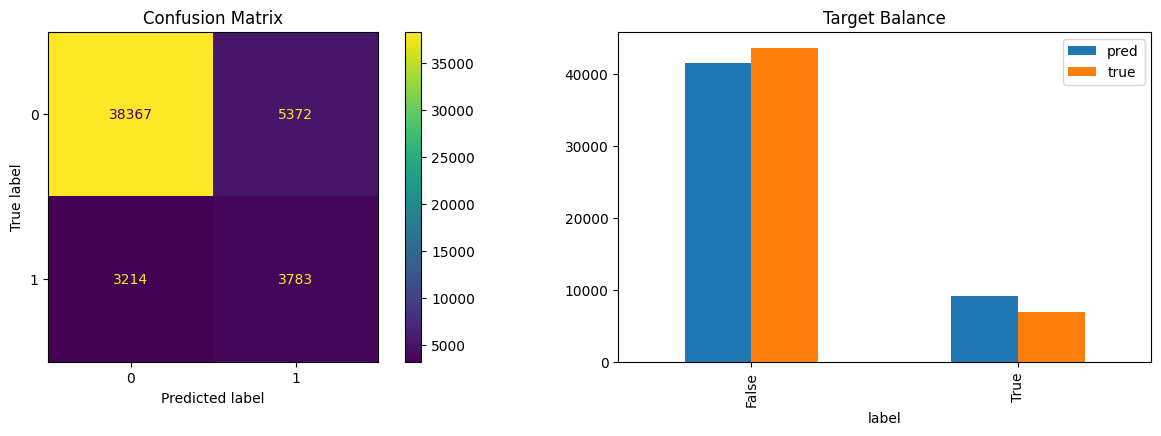

In [20]:
conf_matrix = confusion_matrix(y_test, y_hat_test)

balance = pd.DataFrame(np.unique(y_hat_test, return_counts=True), ["label", "pred"]).T.set_index("label") \
            .merge(pd.DataFrame(Balance_test, ["label", "true"]).T.set_index("label"), on="label")

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(4, 3))  # Adjust the size as needed
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = (["0", "1"]) )
cm_display.plot(ax=ax0)
ax0.set_title('Confusion Matrix')

balance.plot(ax=ax1, kind='bar')
ax1.set_title('Target Balance')

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [21]:
print(classification_report(y_test, y_hat_test, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     43739
           1       0.41      0.54      0.47      6997

    accuracy                           0.83     50736
   macro avg       0.67      0.71      0.68     50736
weighted avg       0.85      0.83      0.84     50736



# VI/ Interpretability 

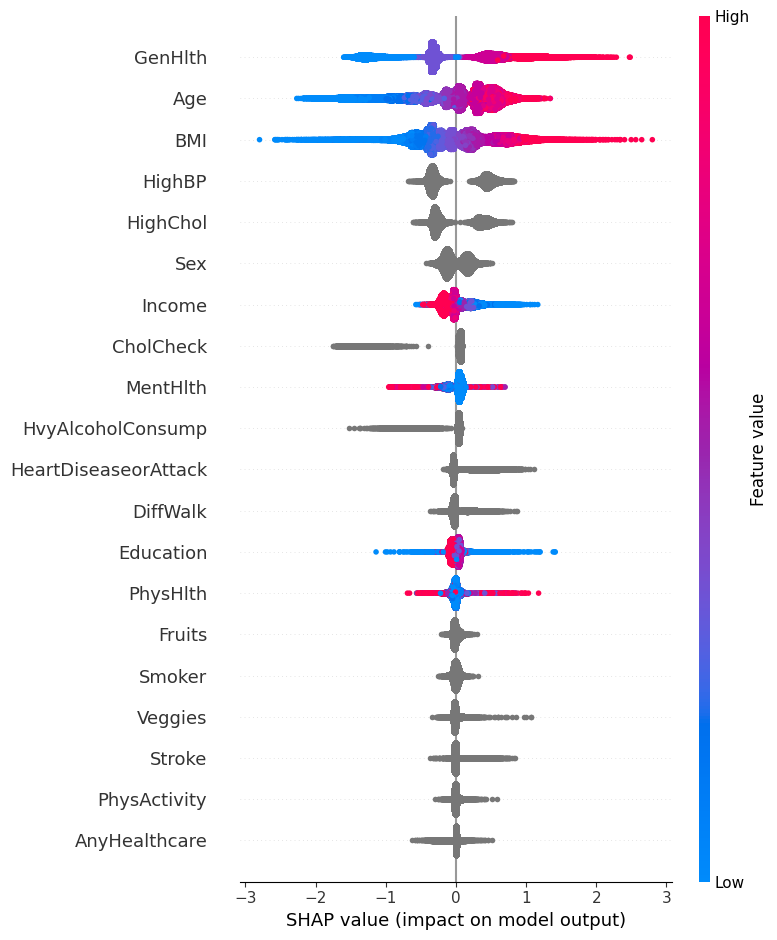

In [22]:
explainer = sp.TreeExplainer(clf_catboost)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train)

# VII/ Final training

In [23]:
clf_catboost = CatBoostClassifier(cat_features = categorical_columns)
clf_catboost = clf_catboost.fit(X, y, verbose = False, plot=True, eval_set= (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
#Result model:

#Probabilités
Y_hat = clf_catboost.predict_proba(X)

#Loss
print("Train loss: ", log_loss(y, Y_hat)) 
print("Train loss (random): ", log_loss(y, np.ones(n)*Prop_test[1]))

Train loss:  0.2907912351198097
Train loss (random):  0.403759361450737
